https://www.aprendemachinelearning.com/clasificacion-de-imagenes-en-python/

https://towardsdatascience.com/image-generation-in-10-minutes-with-generative-adversarial-networks-c2afc56bfa3b

machine learning generate images based on text

## Importacion y dataframe

###Drive

In [77]:
import pandas as pd
import numpy as np

import matplotlib.ticker
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
#procesar imagenes
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image

In [79]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

drive.mount('/content/gdrive')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


https://towardsdatascience.com/how-to-successfully-add-large-data-sets-to-google-drive-130beb320f1a


In [80]:
#@title zip y unzip
# !unzip "/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos/silkroad2_images.zip" -d "/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos"

#-d creates the directory and extracted files are stored there.



# direccion = "Organización de Datos/TPS/TP4/Datos/"
# !unzip ("/content/gdrive/MyDrive/"+direccion+"/test 9 imagenes.zip") -d ("/content/gdrive/MyDrive/"+direccion+"/unziped")
#https://colab.research.google.com/github/sudo-ken/compress-decompress-in-Google-Drive/blob/master/Unrar_Unzip_Rar_Zip_in_GDrive.ipynb#scrollTo=VKdYIG49VaYA



# from zipfile import ZipFile
# with ZipFile("/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos/test 9 imagenes.zip", "r") as archivo:
#   archivo.extractall("/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos/unziped")

#https://www.kaggle.com/mchirico/how-to-read-datasets

In [81]:
downloaded = drive.CreateFile({'id': '1FYEJ8QxvNzDF55EfE9gy_pMEmHftky4_'})
downloaded.GetContentFile('silkroad_items.csv')

items=pd.read_csv('silkroad_items.csv')

In [82]:
# modelos
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# metricas
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from scipy.stats import loguniform

In [83]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)

In [84]:
# kaggle_tests = pd.merge(test_identity, test_transaction, left_on='TransactionID', right_on='TransactionID', how='outer')

###Dataframe

In [85]:
direccion_imagenes = "/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos/unziped/images_by_id/"

In [86]:
with Image.open(direccion_imagenes+'/108.jpg') as im:
    im.rotate(45).show()

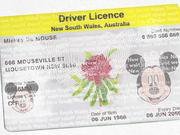

In [87]:
img = load_img(direccion_imagenes+'/108.jpg')
img

#imagenes de 180x135
# https://gianmarco.com.ar/blog/es/blog/silkroad2

####de numpy a imagen y viseversa

https://stackoverflow.com/questions/384759/how-to-convert-a-pil-image-into-a-numpy-array

In [88]:
def pilToNumpy(img):
    return np.array(img)   # im2arr.shape: height x width x channel

def NumpyToPil(img):
    return Image.fromarray(img)

In [ ]:
im = Image.open(direccion_imagenes+'/108.jpg')
pilToNumpy(im)

In [90]:
len(pilToNumpy(im))

135

##analisis exploratorio

https://gianmarco.com.ar/blog/es/blog/silkroad2

In [91]:
#solo conservar items que tengan una imagen asociada
items = items[items['image_id'].notnull()]

In [92]:
items.head()

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
1,the-morality-of-capitalism,The Morality of Capitalism,\n This book has been made available to the...,echo,0.003443,Alcohol,2014-02-23T05:39:29,Undeclared,Undeclared,343.0,2014-02-24/items/the-morality-of-capitalism
2,survive,Survive!,"\n Since the dawn of time, when man first p...",echo,0.001722,Alcohol,2014-02-23T05:39:33,Undeclared,Undeclared,334.0,2014-02-24/items/survive
3,a-non-religious-new-testament,A Non-Religious New Testament,\n This is essentially the Bible written in...,echo,0.015496,Alcohol,2014-02-23T05:39:37,Undeclared,Undeclared,352.0,2014-02-24/items/a-non-religious-new-testament
4,mindless-slogans-101-cheap-substitutes-for-act...,Mindless Slogans: 101 Cheap Substitutes for Ac...,\n Think of all the stupid stuff you overhe...,echo,0.001722,Alcohol,2014-02-23T05:39:41,Undeclared,Undeclared,337.0,2014-02-24/items/mindless-slogans-101-cheap-su...
6,god-wants-you-dead,God Wants You Dead,\n FANTASTIC book for social and cultural d...,echo,0.001722,Drugs,2014-02-23T05:39:48,Undeclared,Undeclared,293.0,2014-02-24/items/god-wants-you-dead


####Primer idea. En base a descripciones generar una imagen

In [ ]:
items[items["description"].str.contains("book", na=False, case=False)].head(3)

hay muchos articulos que en realidad son libros pero que tienen la categoría de alcohol. por lo tanto conviene no usar la categoría para generar las imagenes. 
* en la explicación del dataset dice que solo se pudo obtener la primer categoría del item, pero no la subcategoría más específica

como las categorias son una porquería trato de filtar los datos para generar imagenes de drogas unicamente

In [93]:
items[(items["category"]=="Drugs") & (items["description"].str.contains("book", na=False, case=False) == False)].head()

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
301,bulk-research-chemicals,BULK RESEARCH CHEMICALS,\n Read my vendor profile and contact me to...,TheScienceGuy,0.000000,Drugs,2014-02-23T08:37:40,China,Worldwide,2451.0,2014-02-24/items/bulk-research-chemicals
302,custom-listing-for-mc,Custom Listing for MC,\n 25g 2c-t-2 and 50g methylone for $750 (n...,TheScienceGuy,1.277828,Drugs,2014-02-23T08:37:43,China,Worldwide,3242.0,2014-02-24/items/custom-listing-for-mc
366,do-you-have-bitcoins-to-sell,Do you have BITCOINS to SELL?,"\n I will buy your bitcoins, CASH!\nIf you ...",BTCpal,0.000000,Drugs,2014-02-23T10:00:29,Undeclared,Undeclared,3392.0,2014-02-24/items/do-you-have-bitcoins-to-sell
991,50-grams-of-ketamine,50 grams of Ketamine,\n 50 grams of my fine 98%+ pure Indian sha...,haydenp,3.005410,Drugs,2014-02-23T14:44:24,United States,United States,3918.0,2014-02-24/items/50-grams-of-ketamine
992,one-ounce-28-3-grams-of-ketamine-haydenp,One ounce (28.3 grams) of Ketamine,\n 28.3 grams of my fine 98%+ pure Indian s...,haydenp,1.786721,Drugs,2014-02-23T14:44:40,United States,United States,3917.0,2014-02-24/items/one-ounce-28-3-grams-of-ketam...


aún asi es dificl de comparar con la imagen

In [94]:
with pd.option_context('display.max_colwidth', None):
  display(items[(items["category"]=="Drugs") & (items["description"].str.contains("book", na=False, case=False) == False)][["description", "image_id"]].iloc[115:116,:])

,description,image_id
7521,"\n 1 tablet of 10MG METHADONE (Methadone Hydrochloride) manufactured by Roxane Laboratories, Inc.\n\nMinimum $50 USD per shipment, you may order as many different items you like from my shop. Please select and pay for a shipment option, then select ADD TO OTHER SHIPMENT on the rest.\n",6715.0


####Segunda idea. A partir de una sola palabra

In [ ]:
#en base al titulo
items[(len(items["title"]) == 1)].iloc[30:50,:]

In [ ]:
#en base a la categoría
items[(len(items["title"]) == 1)].iloc[30:50,:]

###cuantas categorías hay?

In [95]:
items.nunique().to_frame().T
# https://www.geeksforgeeks.org/how-to-count-distinct-values-of-a-pandas-dataframe-column/

# df.select_dtypes(exclude = ['number'])

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
0,32379,30263,33802,1281,237817,301,242864,59,28,32539,367673


In [96]:
#cantidad de cada categoría
items["category"].value_counts().to_frame().T

,Alcohol,Stimulants,Weed,Ecstasy,MDMA,Cannabis,Cocaine,LSD,Speed,Drug paraphernalia,Steroids/PEDs,Other,Analgesics,Anabolic Steroids,NBOMe,Benzos,Heroin,Alprazolam,Dissociatives,Drugs,Concentrates,Forgeries,2C-Family,Diazepam,DMT,Oxycodone,Opioids,Digital goods,Sildenafil Citrate,Prescription,Edibles,Shrooms,Books,Apparel,Psychedelics,Chemicals,Relaxants,Pills,Methylphenidate,Tadalafil,...,Herbs & Supplements,25N-NBOMe,Budder,Freebase,LSZ,Herbal Viagra,Mesterolone,Prozac,Suboxone,2-DPMP,Azurescens,Cyanescens,DPT,Liberty Caps,Supplements,Stendra,2C-B-FLY,Strattera,Clones,Snovitra,Dioscorea,Superdrol,Co-codamol,4-HO-MPT,5-MeO-DipT,Tilidine,Pethidine,Anti-inflammatory,Topicals,Aleph-2,Anti-rheumatic,4-ACO-MIPT,Cultures,AMT,Opana,MET,4-HO-MET,Peyote,2C-D,2C-T-4
category,71133,24372,19587,17947,16013,14496,13036,10776,8622,7776,7428,6676,6239,5933,5911,5655,5273,5265,4850,4791,4413,4059,3856,3626,3539,3402,3267,3257,3256,3254,3110,2863,2840,2474,2411,2214,1752,1748,1641,1462,...,7,7,7,7,7,7,6,6,6,5,5,5,5,5,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,2,2,2,1,1,1,1,1


####cosas interesantes/divertidas del dataset

In [97]:
items[items["ships_to"]=="Argentina"]

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
242354,modem,modem,\n get em here\n,pentest002,0.105,Alcohol,2014-09-15T03:40:32,Austria,Argentina,48451.0,2014-09-15/items/modem


###encondings

####MeanEncoding

hecho como $\frac{Fraude}{(Fraude+NoFraude)}$

https://www.geeksforgeeks.org/mean-encoding-machine-learning/


In [98]:
#no modifica el df original

def meanEncoding(dataframe, nombreColumnas):
  temp = dataframe
  for i in nombreColumnas:
    Mean_encoded_subject = dataframe.groupby(i)['isFraud'].mean().to_dict()
    temp[i] =  dataframe[i].map(Mean_encoded_subject)
  return temp

#ejemplo -> df.groupby(['ProductCD'])['isFraud'].mean()

####OneHotEncoding

https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

In [99]:
#no modifica el df original

def oneHotEncoding(df_original, columna):
    dummies = pd.get_dummies(df_original[[columna]])
    res = pd.concat([df_original, dummies], axis=1)
    res = res.drop([columna], axis=1)
    return(res)

####countEncoding

In [100]:
# train.groupby(['ProductCD'])['isFraud'].count()

https://towardsdatascience.com/guide-to-encoding-categorical-features-using-scikit-learn-for-machine-learning-5048997a5c79


https://pbpython.com/categorical-encoding.html

##Extra para leer